### Introduction to Monte Carlo Simulation in Finance
# Multiasset Simulation

## Cholesky Decomposition

The **Choleski Decomposition** makes an appearance in Monte Carlo Methods where it is used to simulating systems with correlated variables.  Cholesky decomposition is applied to the correlation matrix, providing a lower triangular matrix $A$, which when applied to a vector of uncorrelated samples, $u$, produces the covariance vector of the system. Thus it is highly relevant for quantitative trading.

The standard procedure for generating a set of correlated normal random variables is through a linear combination of uncorrelated normal random variables;
Assume we have a set of $n$ independent standard normal random variables $Z$ and we want to build a set of $n$ correlated standard normals $Z^\prime$ with correlation matrix $\Sigma$
$$
Z^\prime = AZ, \quad \quad AA^t = \Sigma
$$

We can find a solution for $A$ in the form of a triangular matrix
$$
\begin{pmatrix} 
A_{11} & 0 & \dots & 0  \\ 
A_{21} & A_{22} & \dots & 0  \\ 
\vdots & \vdots & \ddots & \dots  \\ 
A_{n1} & A_{n2} & \dots & A_{nn}   
\end{pmatrix}
$$

**diagonal elements**
$$
a_{ii} = \sqrt{\Sigma_{ii} - \sum\limits_{k=1}^{i-1} a_{ik}^2}
$$

**off-diagonal elements**
$$
a_{ij} = \frac{1}{a_{ii}} \left( \Sigma_{ij} - \sum\limits_{k=1}^{i-1} a_{ik} a_{jk} \right)
$$

Using Python, the most efficient method in both development and execution time is to make use of the NumPy/SciPy linear algebra (linalg) library, which has a built in method cholesky to decompose a matrix. The optional lower parameter allows us to determine whether a lower or upper triangular matrix is produced: 

In [33]:
import pprint
import scipy
import scipy.linalg   # SciPy Linear Algebra Library

A = scipy.array([[6, 3, 4, 8], [3, 6, 5, 1], [4, 5, 10, 7], [8, 1, 7, 25]])
L = scipy.linalg.cholesky(A, lower=True)
U = scipy.linalg.cholesky(A, lower=False)

print "A:"
pprint.pprint(A)

print "L:"
pprint.pprint(L)

print "U:"
pprint.pprint(U)

A:
array([[ 6,  3,  4,  8],
       [ 3,  6,  5,  1],
       [ 4,  5, 10,  7],
       [ 8,  1,  7, 25]])
L:
array([[ 2.44948974,  0.        ,  0.        ,  0.        ],
       [ 1.22474487,  2.12132034,  0.        ,  0.        ],
       [ 1.63299316,  1.41421356,  2.30940108,  0.        ],
       [ 3.26598632, -1.41421356,  1.58771324,  3.13249102]])
U:
array([[ 2.44948974,  1.22474487,  1.63299316,  3.26598632],
       [ 0.        ,  2.12132034,  1.41421356, -1.41421356],
       [ 0.        ,  0.        ,  2.30940108,  1.58771324],
       [ 0.        ,  0.        ,  0.        ,  3.13249102]])


For example, for a two-dimension random vector we have simply
$$
A=
\begin{pmatrix} 
\sigma_1        & 0   \\ 
\sigma_2 \rho & \sigma_2 \sqrt{1-\rho^2}   
\end{pmatrix}
$$

Say one needs to generate two correlated normal variables $x_1$ and $x_2$. All one needs to do is to generate two uncorrelated Gaussian random variables $z_1$ and$ z_2$ and set
$$
x_1 = z_1 
$$

$$
x_2 =  \rho z_1 + \sqrt{1-\rho^2} z_2
$$

In Python everything you need is available in the *numpy* library, as we can see in the next example.

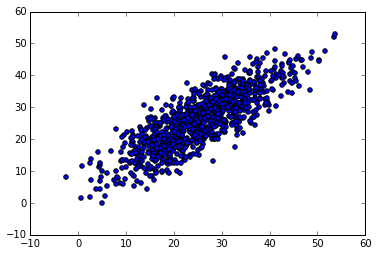

In [ ]:
%matplotlib inline

import numpy as np
import scipy as sc

from math        import sqrt
from scipy.stats import norm as scnorm
from pylab       import *
from matplotlib  import pyplot as pl

xx = np.array([-0.51, 51.2])
yy = np.array([0.33, 51.6])
means = [xx.mean(), yy.mean()]  
stds = [xx.std() / 3, yy.std() / 3]
corr = 0.8         # correlation
covs = [[stds[0]**2          , stds[0]*stds[1]*corr], 
        [stds[0]*stds[1]*corr,           stds[1]**2]] 

m = np.random.multivariate_normal(means, covs, 1000).T
scatter(m[0], m[1])

## Brownian simulation of correlated assets

When using Monte Carlo methods to price options dependent on a basket of underlying assets (multidimensional stochastic simulations), the correlations between assets should be considered. Here I will show an example of how this can be simulated using pandas. 

Download and prepare the data

First we download some data from Yahoo:

In [ ]:
from pandas.io.data import DataReader
from pandas import Panel, DataFrame

symbols = ['AAPL',    # Apple Inc.
           'GLD',     # SPDR Gold Trust ETF
           'SNP',     # S&P 500 Index
           'MCD']     # McDonald's Corporation
data = dict((symbol, DataReader(symbol, "yahoo", pause=1)) for symbol in symbols)
panel = Panel(data).swapaxes('items', 'minor')
closing = panel['Close'].dropna()
closing.head()

Now we can calculate the log returns:

In [ ]:
rets = log(closing / closing.shift(1)).dropna()
rets.head()

The correlation matrix has information about the historical correlations between stocks in the group. We work under the assumption that this quantity is conserved, so the generated stocks will need to satisfy this condition:

In [ ]:
corr_matrix = rets.corr()
corr_matrix

So the most correlated assets are MCD (McDonald's Corporation) and the SPX (S&P 500 Index). Pandas has a nice utility to plot the correlations:

In [ ]:
from pandas.tools.plotting import scatter_matrix

scatter_matrix(rets, figsize=(8,8));

### Simulation

The simulation procedure for generating random variables will go like this:

1. Calculate the Cholesky Decomposition matrix, this step will return an upper triangular matrix  $L^T$.
2. Generate random vector  $X \sim N(0,1)$.
3. Obtain a correlated random vector  $Z=XL^T$.

As we have previously seen the Cholesky decomposition of the correlation matrix corr_matrix is impemented in scipy:

In [ ]:
from scipy.linalg import cholesky

upper_cholesky = cholesky(corr_matrix, lower=False)
upper_cholesky

We set up the parameters for the simulation:

In [ ]:
import numpy as np 
from pandas import bdate_range   # business days

n_days = 21
dates = bdate_range(start=closing.ix[-1].name, periods=n_days)
n_assets = len(symbols)
n_sims = 1000
dt = 1./252
mu = rets.mean().values
sigma = rets.std().values*sqrt(252)
np.random.seed(1234)            # init random number generator for reproducibility

Now we generate the correlated random values $X$:

In [ ]:
rand_values = np.random.standard_normal(size = (n_days * n_sims, n_assets)) #
corr_values = rand_values.dot(upper_cholesky)*sigma
corr_values

With everything set up we can start iterating through the time interval. The results for each specific time are saved along the third axis of a pandas Panel.

In [ ]:
prices = Panel(items=range(n_sims), minor_axis=symbols, major_axis=dates)
prices.ix[:, 0, :] = closing.ix[-1].values.repeat(1000).reshape(4,1000).T # set initial values

for i in range(1,n_days):
    prices.ix[:, i, :] = prices.ix[:, i-1,:] * (exp((mu-0.5*sigma**2)*dt +  sqrt(dt)*corr_values[i::n_days])).T    

prices.ix[123, :, :].head()   # show random path

And thats all! Now it is time to check our results. First a plot of all random paths for AAPL (Apple Inc.).

In [ ]:
prices.ix[::10, :, 'AAPL'].plot(title='AAPL', legend=False);

We can take a look at the statistics for the last day:

In [ ]:
prices.ix[:, -1, :].T.describe()

## Simulating correlated random walks with Copulas

[Very interesting on copula with python...](https://mktstk.com/2015/01/05/simulating-correlated-random-walks-with-copulas/)

[... and this for starting use python with google financial data](https://mktstk.com/2014/12/31/how-to-get-free-intraday-stock-data-with-python/)

Sklar’s Theorem states that any multivariate joint distribution can be written in terms of univariate marginal distribution functions and a copula which describes the dependence structure between the variables.

Copulas are popular in high-dimensional statistical applications as they allow one to easily model and estimate the distribution of random vectors by estimating marginals and copulae separately. There are many parametric copula families available, which usually have parameters that control the strength of dependence

As an example, will focus on the Archimedean family of copulae, specfically the Gumbel copula. The basic idea behind the copula is that you can represent each marginal as a uniform random variable. In general, a copula ($C$) takes the following form:

$$C(u_1,u_2,\dots,u_d)=\mathbb{P}[U_1\leq u_1,U_2\leq u_2,\dots,U_d\leq u_d]$$

Thus given two uniform random variables we can estimate the probability using the Copula function definition. Specifically, the Gumbel copula takes the bivariate form:

$$
\exp\!\left( -\left( (-\log(u))^\theta + (-\log(v))^\theta \right)^{1/\theta} \right)
$$

For example, suppose we want to simulate correlated random walks for Dow Jones and S&P Index. Note the Gumbel copula equation has one parameter, theta (u and v are the marginal uniform distributions of DJI and SP). We can use the python library ambhas to estimate theta for our empirical relationship, which allows us to simulate correlated changes in each stock.

To start the simulation process, we have to download data for the stocks in question. We can do this by downloading intraday stock data from Google Finance and then estimate the copula from the empirical distributions:

In [ ]:
import intraday
import pandas as pd
import numpy as np
from ambhas.copula import Copula
 
base = ".DJI"
hedge = ".INX"
 
interval = 60
window = 15
 
x = intraday.get_google_data(base, interval, window)
y = intraday.get_google_data(hedge, interval, window)

# merge data and convert to log differences
combo = pd.merge(x[['c']], y[['c']], right_index = True, left_index = True)
logs = np.log(combo)
logs = logs.diff().dropna()
 
gumbel = Copula(logs['c_x'], logs['c_y'], 'gumbel') # estimate the copula param
 
x_sim,y_sim = gumbel.generate_xy(50000)             # this does the simulation

Now x_sim and y_sim are simulated log changes in DJI and SP, respectively. Thus we can use the exponential function in numpy to convert these changes back into realistic looking prices:

In [ ]:
scatter(x_sim, y_sim)

In [ ]:
#x_sum = x['c'].values[-1] * np.exp(x_sim.cumsum())
#y_sum = y['c'].values[-1] * np.exp(y_sim.cumsum())

x_sum = 100 * np.exp(x_sim.cumsum())
y_sum = 100 * np.exp(y_sim.cumsum())

This uses the last price from the empirical data series as the starting price for each stock in our simulated random walks. Now we can plot the two and get a realistic looking graph:

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(x_sum)
plt.plot(y_sum)

The ambhas library has a number of dependencies you should make sure are installed before using the code above. These dependencies are described here. N. B.: we had to uninstall our current python statistics module and re-install using the instructions here. Otherwise you might get an error like “could not find cpdf in module” or some such. Making sure you have all dependencies installed should resolve this.